# IdiomCheck - Language Detection

Here I detail my attempts to create a language classifier trained on the [European Parliament Proceedings Parallel Corpus](http://www.statmt.org/europarl/) and tested using [this](https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/language-detection/europarl-test.zip) dataset.

I use three approaches:
- [N-gram frequency distribution comparison](#rank)
- [Markov chain MLE](#markov)
- [LSTM-based neural network](#lstm)

The best-performing model was the Markov chain MLE which produced a classification accuracy of **99.77%**.

[Model Performance Summary](#summary)

## Data Preprocessing

In [2]:
# -*- coding: utf-8 -*-

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import os
import glob
import numpy as np
import pandas as pd
import string
from tqdm import tqdm_notebook as tqdm
from pandas_ml import ConfusionMatrix

In [64]:
def string_cleaner(sample):
    '''
    Takes a string and removes unwanted characters/formatting
    '''
    
    sample = re.sub(r'[^\u0000-\u0800]', '', sample) # select only the first 2048 UTF-8 characters
    sample = re.sub(r'\([^)]*\)', ' ', sample) # rm characters within brackets
    sample = re.sub('<[^>]+>', '', sample) # rm characters within <>
    sample = re.sub(r'\d+', '', sample) # rm one or more digits
    sample = sample.replace('\n', ' ') # rm line delimiters
    sample = re.sub(r'/[^\w\s]/gi', '', sample)
    sample = re.sub(r'\W+', ' ', sample) # rm non-word characters
    sample = re.sub("'", '', sample) # rm single quotes
    sample = sample.lower() # make lowercase
    sample = re.sub(r'^\s','', sample) # rm space at start
    sample = re.sub(r'\s$','', sample) # rm space at end
    
    return sample

In [9]:
def corpus(file_list, clean=True):
    '''
    Inputs:
    file_list - the list of paths of the text files to create the corpus
    clean - bool - if True: applies string_cleaner() to the strings
    
    Returns:
    A list of strings containing the corpus
    '''
    corpus = []

    for file_path in file_list:
        with open(file_path) as f_input:
            sample = f_input.read()[:20000] # take first 20000 characters of each file for sake of computation time / memory constraints
            if clean:
                sample = string_cleaner(sample)
            if len(sample) > 0:
                corpus.append(sample)

    return corpus

In [8]:
file_list = glob.glob(os.path.join(os.getcwd(), "txt", "bg","*.txt"))
the_corpus = corpus(file_list[:50], clean=False)
the_corpus[12]

'<CHAPTER ID="006">\nИзбор на квестори на Европейския парламент (срок за депозиране на кандидатури): вж. протокола\n<P>\n(Die Sitzung wird um 15.25 Uhr unterbrochen und um 18.00 Uhr wiederaufgenommen).\n'

This Bulgarian sample above contains a number of characters and formatting we wish to remove (including some German in brackets). Have altered `string_cleaner()` accordingly.

In [10]:
the_corpus = corpus(file_list[:50])
the_corpus[12]

'избор на квестори на европейския парламент вж протокола'

Now they've been removed, great. It has also removed all other text in brackets but this will be in a minority of cases.

In [11]:
file_list = glob.glob(os.path.join(os.getcwd(), "txt", "cs","*.txt"))
the_corpus = corpus(file_list[:50])

In [12]:
print(the_corpus[0])
print(the_corpus[1])
print(the_corpus[2])

schválení zápisu z předchozího zasedání viz zápis
členství ve výborech a delegacích viz zápis
předložení dokumentů viz zápis


Many of the early files contain the same ending (`viz zápis`) which we should strip as these will effect the models. Luckily each language has the same phrase after the colon in the same corresponding file. My guess is that this doesn't affect the overall statistics though, given that it'll be lost amongst large text files. We can always come back and alter this.

## Test Data

The test data comes as a .tsv file with the first column representing the language and the second column containing the string of text.

In [13]:
test = pd.read_csv('europarl-test.txt', sep='\t', header=None, names=['language', 'string'])

In [14]:
test.head()

,language,string
0,bg,Европа 2020 не трябва да стартира нов конкурен...
1,bg,(CS) Най-голямата несправедливост на сегашната...
2,bg,"(DE) Г-жо председател, г-н член на Комисията, ..."
3,bg,"(DE) Г-н председател, бих искал да започна с к..."
4,bg,"(DE) Г-н председател, въпросът за правата на ч..."


Next we need to strip the '(CS)','(DE)' etc. As well as all the non-alphanumeric characters.

In [15]:
test['string'] = test['string'].apply(lambda x: string_cleaner(x))
test = test[test['string'].apply(len) != 0] # remove empty strings
test.head()

,language,string
0,bg,европа не трябва да стартира нов конкурентен м...
1,bg,най голямата несправедливост на сегашната обща...
2,bg,г жо председател г н член на комисията по прин...
3,bg,г н председател бих искал да започна с комента...
4,bg,г н председател въпросът за правата на човека ...


We also need to remove the rows with empty strings.

In [16]:
test.shape

(20762, 2)

So we have a test dataset of 20828 samples. 

In [17]:
languages = next(os.walk('./txt'))[1]
np.array(languages)

array(['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu',
       'it', 'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv'],
      dtype='<U2')

In [18]:
test.language.unique()

array(['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu',
       'it', 'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv'],
      dtype=object)

In [19]:
set(test.language.unique()).issubset(languages)

True

Therefore all of the languages in the test dataset are in the training dataset, this is good.

In [20]:
from matplotlib import pyplot as plt

Median string length: 131 characters


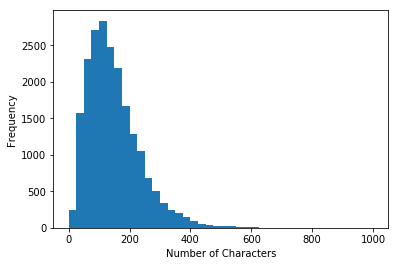

In [21]:
lengths = [len(x) for x in test['string']]
plt.ylabel('Frequency')
plt.xlabel('Number of Characters')
plt.hist(lengths,40, range=(0,1000))
print('Median string length: %.0f characters' % np.median(lengths))

<a id='rank'></a>
## N-gram Rank Similarity Method

I'm going to first try a [traditional method](http://odur.let.rug.nl/vannoord/TextCat/textcat.pdf) of ranked n-gram frequency similarity. I'll carry this out at the character level, since some of the test samples may be very short - we want to create a meaningful rank distribution.

The authors in the linked paper use a simple rank similarity metric of the average distance between characters in the two ranks being compared. When comparing multiple languages, the language which produces the _smallest_ value of this metric is deemed the model's best prediction.

It is unclear how the authors deal with n-grams which aren't mutually contained in the two ranks being compared. They simply write "no-match = max" which I've interpreted as setting no-matches equal to the max distance, which is equal to the length of the rank. The authors also report good classification for rank lengths as short as 200, so I shall use this rank length (perhaps experimenting later on). 

In [22]:
def rank_sim(a, b):
    '''
    Takes two ranked arrays of the same shape and returns the average distance between the indices of matching elements
    Elements which don't match are given a distance of the length of the array (this will perform poorly on short strings)
    '''
    c = a[np.where(np.in1d(a,b))[0]]
    d = c.reshape((len(c),1))
    e = np.abs(np.where(np.in1d(a,b))[0]-np.where(d==b)[1])
    no_match_penalty = (len(a)-len(e))*len(a) # TODO: make this condition more rigourous
    
    return (e.sum() + no_match_penalty)/len(a)

In [23]:
def rank(corpus, ngram_range=(1,3), rank_length=200):
    '''
    Inputs:
    corpus - a list of strings
    ngram_range - the range of ngram lengths to consider (defaults to 1-3)
    rank_length - the length of the rank list to return (defaults to 200)
    
    Retuns:
    rank - the array of ngrams ordered by frequency of occurrence in the corpus
    '''
    vectorizer = TfidfVectorizer(input='content',ngram_range=(1,3), analyzer='char_wb')
    transformed = vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names()
    sums = transformed.sum(axis=0)
    
    return np.array(features)[np.array(np.argsort(sums[0,:]))[0]][-rank_length:]

### Initial Test

Let's try the functions on some example data.

In [24]:
file_list_sl = glob.glob(os.path.join(os.getcwd(), "txt", "sl","*.txt"))
file_list_lv = glob.glob(os.path.join(os.getcwd(), "txt", "lv","*.txt"))

In [25]:
corpus_sl_1 = corpus(file_list_sl[:50])
corpus_sl_2 = corpus(file_list_sl[50:100])
corpus_lv_1 = corpus(file_list_lv[:50])
corpus_lv_2 = corpus(file_list_lv[50:100])

rank_sl_1 = rank(corpus_sl_1)
rank_sl_2 = rank(corpus_sl_2)
rank_lv_1 = rank(corpus_lv_1)
rank_lv_2 = rank(corpus_lv_2)

print('Slovakian/Latvian similarity score:', rank_sim(rank_sl_1, rank_lv_1))
print('Slovakian/Slovakian similarity score:', rank_sim(rank_sl_1, rank_sl_2))
print('Latvian/Latvian similarity score:', rank_sim(rank_lv_1, rank_lv_2))

Slovakian/Latvian similarity score: 138.335
Slovakian/Slovakian similarity score: 49.7
Latvian/Latvian similarity score: 60.48


We can see that both languages show similarity to themselves (a low score means a stronger agreement between their ranks), and less similarity between each other. In this simple binary classification, the two languages would have been told apart.

### Extracting Ranks

All we will need to classify a given sample of text are the ranked ngrams for each language after analysing the whole dataset.

In [ ]:
ranks = {}

for language in tqdm(languages):
    file_list = glob.glob(os.path.join(os.getcwd(), "txt", language,"*.txt"))
    lang_corpus = corpus(file_list[:500])
    lang_rank = rank(lang_corpus, rank_length=100)
    ranks[language] = lang_rank

### Evaluating N-gram Rank Similarity model

In [27]:
def idiom_check(lang_sample, ranks, print_scores=False):
    '''
    Inputs:
    lang_sample - the string to be classified
    ranks - the dict() containing the language keys and their corresponding ranks
    print_scores - bool - if True, the scores for each separate language is printed
    
    Returns:
    The predicted language of lang_sample
    '''
    scores = {}
    
    sample_rank = rank([lang_sample])
    
    for key, rk in ranks.items():
        scores[key] = rank_sim(sample_rank, rk)
        
    if print_scores:
        print(scores)

    return min(scores, key=scores.get)

In [30]:
results = test.copy()
results['pred_lang'] = results['string'].apply(lambda x: idiom_check(x, ranks))

In [31]:
print('Accuracy:',(results['language'] == results['pred_lang']).sum()/len(results))

Accuracy: 0.8040169540506695


This isn't terrible, but we could do better. We could probably improve this method by training the model on a larger dataset, but given the constraints of my machine, I couldn't do this.

Let's produce a confusion matrix from the results.

In [33]:
confusion_matrix = ConfusionMatrix(results['language'], results['pred_lang'])
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted    bg   cs    da    de   el    en   es   et    fi    fr   ...     \
Actual                                                              ...      
bg          994    3     0     0    0     0    0    0     0     0   ...      
cs            2  645    18     3    0    16    1   15    40     6   ...      
da            3    0   950     2    0     3    0    1     0     1   ...      
de            1    0     7   969    0     0    1    0     0     0   ...      
el            1    0     0     0  986     0    0    0     0     0   ...      
en            2    0     5     4    0   950    1    0     0    10   ...      
es            1    1     1     2    0     2  873    1     0    10   ...      
et            3    0    10     3    0     1    0  473   456     1   ...      
fi            1    0     2     1    0     0    0    1   987     0   ...      
fr            4    0     5     3    0     0   13    0     0   946   ...      
hu            5    1   221     6    0     8   

The errors seem to come mainly from Estonian, Hungarian, Romanian and Slovakian. Let's try a different method.

<a id='markov'></a>
## Markov Chain MLE

The n-gram approach works fine, but isn't very well suited to short strings which don't contain a large number of unique n-grams. I believe a character-level Markov chain approach could perform better on shorter phrases because it doesn't have this limitation. 

I aim to treat each string as a first-order Markov chain and then extract the character-level transition matrix for each language. Then I can calculate the $\log(probability)$ for a particular string to belong to each language and choose the maximally likely option. Something along the lines of [this](https://pdfs.semanticscholar.org/2bf0/8addb83f51befa8b4bc7ed16b54ed34018d0.pdf) I suppose. I have chosen to ignore the initial character probabilities, as their contribution to the final result is likely to be very small. However, this means that what I construct here is not technically a true Markov chain.

There don't seem to be any Python packages for markov chains(?!) I will have to code this myself.

### Model

In [36]:
# From - stackoverflow.com/a/43413801

def strided_axis0(a, L):
    # Store the shape and strides info
    shp = a.shape
    s  = a.strides

    # Compute length of output array along the first axis
    nd0 = shp[0]-L+1

    # Setup shape and strides for use with np.lib.stride_tricks.as_strided
    # and get (n+1) dim output array
    shp_in = (nd0,L)+shp[1:]
    strd_in = (s[0],) + s
    return np.lib.stride_tricks.as_strided(a, shape=shp_in, strides=strd_in)

This gives us the transitions as required.

In [37]:
trial = "This is a test"
test_arr = np.array(list(trial))
pairs = strided_axis0(test_arr, 2)
pairs[:10]

array([['T', 'h'],
       ['h', 'i'],
       ['i', 's'],
       ['s', ' '],
       [' ', 'i'],
       ['i', 's'],
       ['s', ' '],
       [' ', 'a'],
       ['a', ' '],
       [' ', 't']], dtype='<U1')

In [38]:
len(strided_axis0(test_arr, 2))

13

In [39]:
len(np.unique(strided_axis0(test_arr, 2), axis=0))

11

We can see that there are only 11 unique transitions out of 13 measured transitions - this is how we will build our transition matrix.

Our transition matrix could end up being quite large. We already have over 16,000 entries for the 128 characters in US-ASCII, if we extend this to the Greek characters then this could be around 4,000,000 entries.

It's probably best to store these as a (vectorised) numpy array. We will now write a function to integer-encode each character.

In [40]:
def int_encode(groups, encoder):
    '''
    Input:
    groups - array - groups of characters to be encoded
    encoder - a sklearn.preprocessing.LabelEncoder object which has been prefitted to a vocabulary
    
    Returns:
    int_encoded - array - the integer encoded groups
    '''
    flat_groups = groups.flatten()
    try:
        int_encoded = encoder.transform(flat_groups).reshape(groups.shape)
    except ValueError:
        print('Error:',''.join(list(groups[:,1])))
    
    return int_encoded

We need to work out a way of dealing with the zero-valued probabilities - these are events that aren't in the training data, but could be seen in the test data. For this it seems we should use some kind of [smoothing](https://pdfs.semanticscholar.org/5b2b/78087e51641a02966d6dcf20b51a5c43ccca.pdf). I should use _absolute discounting_ as it is easy to implement and apparently quite effective (would ideally use _Kneser-Ney smoothing_ but this would be very involved). [Here](http://u.cs.biu.ac.il/~yogo/courses/mt2013/papers/chen-goodman-99.pdf) is a good guide.

However, this still seems too time-consuming. It may suffice to add a very small amount of probability to the zero values, we'll see when we test the model.

In [41]:
def smooth(trans_mat):
    '''
    Smooths zero values with a small number << 1 (an altered form of Laplace smoothing)
    
    TODO: turn this into Kneser-Ney smoothing
    
    '''
    smooth_prob = trans_mat[(trans_mat != 0) & ~np.isnan(trans_mat)].min()/10 # take the minimum probability and choose something smaller than it
    trans_mat[trans_mat == 0] = smooth_prob
    trans_mat[np.isnan(trans_mat)] = smooth_prob
    
    return trans_mat

In [42]:
def transition_matrix(text_list, vocab, encoder):
    '''
    Input:
    text_list - list of strings - the texts to analyse
    
    Returns:
    trans_mat - array - the Markovian transition matrix for the text given
    vocab - array - an array where the index of each item corresponds to the position in trans_mat: a lookup
    '''
    count_mat_master = np.zeros((vocab.shape[0],vocab.shape[0])) # intialise the master count matrix with zero counts
    
    for text in tqdm(text_list):
        if len(text) < 2:
            continue
        text = np.array(list(text)) # prepare text as array of separate characters
        pairs = strided_axis0(text, 2) # window characters into consecutive pairs
        int_pairs = int_encode(pairs, encoder) # integer encode the characters
        unique, counts = np.unique(int_pairs, return_counts=True, axis=0) # count the separate instances of the transitions
        count_mat = np.zeros((vocab.shape[0],vocab.shape[0]))
        count_mat[unique[:,0],unique[:,1]] = counts # populate the count matrix
        count_mat_master += count_mat # add the counts to the master count matrix
        
    count_mat_master = smooth(count_mat_master)
    trans_mat = count_mat_master/count_mat_master.sum(axis=1).reshape(count_mat_master.shape[0],1) # normalise the transition matrix (row stochastic)
    
    return trans_mat, vocab

In [43]:
def log_like(text, TM_list, encoder):
    '''
    Inputs:
    text - string - the sample to be analysed
    TM_list - array - the list of transition matrices containing the transition probabilities for the calculation for each langauge
    encoder - LabelEncoder() object - the fitted LabelEncoder() object to integer encode the text
    
    Returns:
    log_likelihood - float - the log-likelihood for the string
    
    '''
    text = np.array(list(text))
    pairs = strided_axis0(text, 2)
    int_pairs = int_encode(pairs, encoder)
    prob_lists = np.zeros((TM_list.shape[0], int_pairs.shape[0]))
    
    for i, TM in enumerate(TM_list):
        prob_lists[i] = TM[int_pairs[:,0],int_pairs[:,1]]
    
    return np.log(prob_lists).sum(axis=1)

Now I need to extract my vocab from the training data, or I could create a sample of every character that's possible to create with two bytes of UTF-8? Let's try using the first $128 + 1920 = 2,048$ characters. We have filtered to these characters in our text preprocessing anyway. This will be a very sparse matrix, but not too large for our means.

In [44]:
vocab = np.array([chr(i) for i in range(2048)])
encoder = LabelEncoder().fit(vocab)

### Preliminary Test

Let's test the routines on our previous example.

In [147]:
file_list_sl = glob.glob(os.path.join(os.getcwd(), "txt", "sl","*.txt"))
file_list_lv = glob.glob(os.path.join(os.getcwd(), "txt", "lv","*.txt"))

# Produce corpora
corpus_sl_1 = corpus(file_list_sl[:50])
corpus_sl_2 = corpus(file_list_sl[50:100])
corpus_lv_1 = corpus(file_list_lv[:50])
corpus_lv_2 = corpus(file_list_lv[50:100])

In [ ]:
# Populate tranisition matrices
TM_list = np.array([transition_matrix(corpus, vocab, encoder)[0] for corpus in [corpus_sl_1, corpus_lv_1]])

In [149]:
# Produce log-likelihoods
log_likes = np.zeros((len(corpus_sl_2),len(TM_list)))
for i, sample in enumerate(corpus_sl_2):
    log_likes[i,:] = log_like(sample, TM_list, encoder)

In [150]:
percentage_accuracy = 100*(np.where(log_likes[:,0] > log_likes[:,1])[0].shape[0] / log_likes.shape[0])
print("Binary detection accuracy: %d%%" % percentage_accuracy)

Binary detection accuracy: 100%


So the model does indeed produce a larger log likelihood for the correct language, this is great. Now I need to create transition matrices for all of the languages and evaluate the model on the whole dataset.

### Evaluating Markov Chain MLE model

In [45]:
languages

['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu', 'it', 'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv']

In [ ]:
TM_list = np.zeros((len(languages), len(vocab), len(vocab)))

for i, language in enumerate(tqdm(languages)):
    file_list = glob.glob(os.path.join(os.getcwd(), "txt", language,"*.txt"))
    a_corpus = corpus(file_list[:4000]) # take first 4000 files for sake of computation time
    TM_list[i] = transition_matrix(a_corpus, vocab, encoder)[0]

Now let's evaluate the performance on our test dataset.

In [47]:
def idiom_check_mkv(lang_sample, TM_list, languages, encoder):
    '''
    Inputs:
    lang_sample - the string to be classified
    TM_list - array containing the transition matrices for each language
    languages - list - list of the two character strings representing each language
    encoder - sklearn.preprocessing.LabelEncoder obj - prefitted encoder
    
    Returns:
    The predicted language of lang_sample - string
    '''

    return languages[np.argmax(log_like(lang_sample, TM_list, encoder))]

In [79]:
results = test.copy()
results['pred_lang'] = results['string'].apply(lambda x: idiom_check_mkv(x, TM_list, languages, encoder))

In [80]:
print('Accuracy:',(results['language'] == results['pred_lang']).sum()/len(results))

Accuracy: 0.9977362489162894


99.77% is comparable if not better than the performance [reported in the literature](https://pdfs.semanticscholar.org/2bf0/8addb83f51befa8b4bc7ed16b54ed34018d0.pdf), although we are of course using a different test dataset. I think at this point improvements would have to come either by using a larger sample for the transition matrices, or by improving on the smoothing technique (which is very rudimentary as it stands). Let's look to see where it failed.

In [83]:
confusion_matrix = ConfusionMatrix(results['language'], results['pred_lang'])
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted   bg   cs   da   de   el    en   es   et   fi   fr   ...      lt  \
Actual                                                         ...           
bg         997    0    0    0    0     0    0    0    0    0   ...       0   
cs           0  985    0    0    0     1    0    0    0    0   ...       0   
da           0    0  989    0    0     0    0    0    0    0   ...       0   
de           0    0    0  991    0     1    0    0    0    0   ...       0   
el           0    0    0    0  988     0    0    0    0    0   ...       0   
en           0    1    0    0    0   998    0    0    0    0   ...       0   
es           0    0    0    0    0     0  993    0    0    0   ...       0   
et           0    0    0    0    0     0    0  993    0    0   ...       0   
fi           0    0    0    0    0     0    0    0  994    0   ...       0   
fr           0    0    0    1    0     1    1    0    0  993   ...       0   
hu           0    0    0    0    0     0    0 

In [119]:
errors = results[results['language'] != results['pred_lang']].reset_index(drop=True)

In [115]:
print('Number of errors:',len(errors))

Number of errors: 47


Let's return the top five languages by number of errors.

In [117]:
errors.groupby('language')['pred_lang'].count().reset_index(name='count').sort_values('count',ascending=False).reset_index(drop=True).loc[:4,:]

,language,count
0,cs,8
1,fr,6
2,da,5
3,sk,4
4,es,4


Let's look at some examples. I can only really make inferences from languages I can understand, but I think this will still capture some general problems with the model.

In [130]:
# Helper function
def print_example(df, ind):
    row = df.loc[ind]
    print('True: ', row['language'], sep='')
    print('Predicted: ', row['pred_lang'], sep='')
    print(row['string'], sep='')

Some of the errors contain samples of the predicted language which is obviously throwing the model.

In [131]:
print_example(errors, 3)

True: cs
Predicted: en
jmenovali se william meyer bernard starie reginald pike thomas shaw james mcleish archibald barrowman a albert roberts a všichni budou v sobotu vyznamenáni


Here, the English names are probably weighting the prediction in favour of English rather than Swiss.

Similarly in this short example:

In [132]:
print_example(errors, 14)

True: de
Predicted: en
danke herr macartney


Others show an obvious resemblance, containing shared (or very similar) words between the languages:

In [134]:
print_example(errors, 23)

True: fr
Predicted: en
la directive habitat impose un objectif explicite


One could probably improve on these errors by using a higher-order Markov Model (involving probabilities of trigrams etc.), moving from a transition 'matrix' to a higher order tensor. This would be computationally much more expensive, but could prove to be very accurate.

In the above example, such a higher order system would find that whilst the probabilties for the transitions 'un' and 'if' were probably fairly similar between French and English, the probabilties for 'un ' and 'tif' would be much higher in the former language. 

<a id='lstm'></a>
## LSTM Model

I'm going to try training a simple LSTM-based neural network on the language data using TensorFlow to see if I can get a similar (or even better?) accuracy.

In [34]:
%load_ext autoreload
%autoreload 2

In [35]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from utils import makeDF, corpus

Using TensorFlow backend.


In [36]:
vocab = np.array([chr(i) for i in range(2048)])
encoder = LabelEncoder().fit(vocab)

languages = next(os.walk('./txt'))[1]
language_encoder = LabelEncoder().fit(languages)

### Data Preprocessing

Let's process our data so it can be read by TensorFlow.

In [ ]:
sequences_per_lang = 1000

# Train data
train = makeDF(os.getcwd(),sequences_per_lang)
train['as_numbers'] = train['string'].apply(lambda x: encoder.transform(list(x)))
train['length'] = train['string'].apply(lambda x: len(x))
train['lang_as_numbers'] = language_encoder.transform(train['language'])

# Test data
test = pd.read_csv('europarl-test.txt', sep='\t', header=None, names=['language', 'string'])
test['string'] = test['string'].apply(lambda x: re.sub(r'[^\u0000-\u0800]', '', x))
test = test[test['string'].apply(len) != 0] # remove empty strings
test['as_numbers'] = test['string'].apply(lambda x: encoder.transform(list(x)))
test['length'] = test['string'].apply(lambda x: len(x))
test['lang_as_numbers'] = language_encoder.transform(test['language'])

# Validation/test split
test_len = len(test)
rand_inds = np.random.choice(test_len,test_len)
val = test.iloc[rand_inds[test_len//2:]]
test = test.iloc[rand_inds[:test_len//2]]

In [38]:
print('Test shape: ', test.shape,'\n', 'Validation Shape: ', val.shape, sep='')

Test shape: (10414, 5)
Validation Shape: (10414, 5)


In [39]:
class PaddedDataIterator():
    def __init__(self, df, maxlen):
        self.df = df
        self.maxlen = maxlen
        self.rm_too_short()
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()
        
    # Remove sequences with fewer items than maxlen
    def rm_too_short(self):
        self.df = self.df.drop(self.df[self.df['length'] < self.maxlen].index).reset_index(drop=True)

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.loc[self.cursor:self.cursor+n-1]
        if len(res) != n:
            print(res)
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        # maxlen = max(res['length'])
        maxlen = self.maxlen
        x = pad_sequences(res['as_numbers'].values, maxlen, padding='post', truncating='post')

        return x, res['lang_as_numbers'].values, np.array([maxlen]*x.shape[0])

### Model

In [40]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    
def build_graph(
    vocab_size = len(vocab),
    state_size = 64,
    batch_size = 32,
    num_classes = len(languages),
    learning_rate = 1e-3):

    reset_graph()

    # Placeholders
    x = tf.placeholder(tf.int32, shape=[batch_size, None]) # [batch_size, num_steps]
    seqlen = tf.placeholder(tf.int32, shape=[batch_size])
    y = tf.placeholder(tf.int32, shape=[batch_size])
    keep_prob = tf.placeholder(tf.float32,[])

    # Embedding layer
    embeddings = tf.get_variable('embedding_matrix', shape=[vocab_size, state_size])
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)

    # LSTM
    lstmCell = tf.nn.rnn_cell.LSTMCell(state_size, name='basic_lstm_cell')
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=keep_prob)
    rnn_outputs, _ = tf.nn.dynamic_rnn(lstmCell, rnn_inputs, dtype=tf.float32)
    
    # Bidirectional LSTM - doesn't really work
    # lstmCell_fw = tf.nn.rnn_cell.LSTMCell(state_size, name='basic_lstm_cell')
    # lstmCell_fw = tf.contrib.rnn.DropoutWrapper(cell=lstmCell_fw, output_keep_prob=keep_prob)
    # lstmCell_bw = tf.nn.rnn_cell.LSTMCell(state_size, name='basic_lstm_cell')
    # lstmCell_bw = tf.contrib.rnn.DropoutWrapper(cell=lstmCell_bw, output_keep_prob=keep_prob)
    # rnn_outputs, _ = tf.nn.bidirectional_dynamic_rnn(lstmCell_fw, lstmCell_bw, rnn_inputs, dtype=tf.float32)
    
    # Add dropout, as the model otherwise quickly overfits
    # rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)

    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)

    # Softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    logits = tf.matmul(last_rnn_output, W) + b
    preds = tf.nn.softmax(logits)
    correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'keep_prob': keep_prob,
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy
    }

### Training

In [62]:
def train_graph(graph, batch_size = 32, num_epochs = 16, iterator = PaddedDataIterator):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        keep_prob = 0.6
        maxlen = 64
        tr = iterator(train, maxlen)
        te = iterator(val, maxlen)
        g = graph

        step, accuracy = 0, 0
        tr_losses, te_losses = [], []
        current_epoch = 0
        while current_epoch < num_epochs:
            step += 1
            batch = tr.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['keep_prob']: keep_prob}
            accuracy_, _ = sess.run([g['accuracy'], g['ts']], feed_dict=feed)
            accuracy += accuracy_

            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_losses.append(accuracy / step)
                step, accuracy = 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    batch = te.next_batch(batch_size)
                    feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['keep_prob']: keep_prob}
                    accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
                    accuracy += accuracy_

                te_losses.append(accuracy / step)
                step, accuracy = 0,0
                print("Accuracy after epoch", current_epoch, " - acc:", tr_losses[-1], "- val_acc:", te_losses[-1])
        
        # Evaluate on test data
        tes = iterator(test, maxlen)
        step, accuracy = 0, 0
        while tes.epochs == 0:
            step += 1
            batch = tes.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['keep_prob']: keep_prob}
            accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
            accuracy += accuracy_
        
        print('\n')
        print('Accuracy:', accuracy/step)

    return tr_losses, te_losses

In [63]:
g = build_graph()
tr_losses, te_losses = train_graph(g)

/Users/JBremner/Envs/idiom/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Accuracy after epoch 1  - acc: 0.30414438502673796 - val_acc: 0.3974014336917563
Accuracy after epoch 2  - acc: 0.5069537533512064 - val_acc: 0.5198965827338129
Accuracy after epoch 3  - acc: 0.646196380697051 - val_acc: 0.6616456834532374
Accuracy after epoch 4  - acc: 0.7301441018766756 - val_acc: 0.7107688848920863
Accuracy after epoch 5  - acc: 0.7838471849865952 - val_acc: 0.7475269784172662
Accuracy after epoch 6  - acc: 0.8348693029490617 - val_acc: 0.7794514388489209
Accuracy after epoch 7  - acc: 0.863103217158177 - val_acc: 0.795863309352518
Accuracy after epoch 8  - acc: 0.8754189008042895 - val_acc: 0.7808003597122302
Accuracy after epoch 9  - acc: 0.8877345844504021 - val_acc: 0.8068794964028777
Accuracy after epoch 10  - acc: 0.9059148793565683 - val_acc: 0.8223920863309353
Accuracy after epoch 11  - acc: 0.9121983914209115 - val_acc: 0.8399280575539568
Accuracy after epoch 12  - acc: 0.9141253351206434 - val_acc: 0.8310476618705036
Accuracy after epoch 13  - acc: 0.91931

86% is not bad for this problem, but I'm sure I could do better if I fine-tuned the model and trained it with a proper backend (and more training sequences).

<a id='summary'></a>

## Summary

Here I shall summarise the three approaches I took for this language classification problem.

### N-gram Rank Similarity

**Accuracy:** 80.40%

> #### Pros
> - Simple
> - Easy to train

> #### Cons
> - Very poor for short sequences of text

> #### Improvements
> - Larger training dataset

### Markov Chain MLE

**Accuracy:** 99.77%

> #### Pros
> - The best performing model


> #### Cons
> - A little more expensive to evaluate for longer strings
> - Smoothing transition matrices difficult

> #### Improvements
> - Implement _Kneser-Ney_ smoothing
> - Higher-order Markov Model
> - Larger training dataset

### LSTM

**Accuracy:** 86.26%

> #### Pros
> - Straightforward to evaluate

> #### Cons
> - Complex
> - Difficult to train
> - Takes fixed string input length

> #### Improvements
> - Larger training dataset (with a better backend)
> - Fine-tune model parameters
> - Try more sophisticated implementations (more layers, bidirectional etc.)